In [48]:
from graphviz import Digraph
# Process: Root gets activated by calling an activation task (defined and assigned to root runtime), root performs the task,
# saves the result in a 'context', calls the children's isActivationEligible by passing the context to the child,  
# every child that is eligible for activation does the same for its children. The path that is taken is relevant to the test data
# passed on the initial context. Once all test data is exhausted, all the un-visited nodes are shown (all nodes that haven't been visited
# after all test data is run, per test data obviously not all nodes will be visited because each test data will select a single flow
# to run) 

# Questions: Who should handle context - driver or node class. Used driver since context needs to be available across all nodes
# 2. How does the 'prior action results' object flow through the nodes? For now setting it on top node and having it flow through to children
# 3. How does the 'curr test data' object flow through the nodes? Same as above, but setting it on isActivationEligible

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((v, child))
                build(child)
    build(root)
    return nodes, edges

class Node:
    def __init__(self, description):
        self.description = description
        self.children = []
        self.testData = []
    
    def __repr__(self):
        return f"{self.description}"
    
    def addChild(self, child):
        self.children.append(child)
    
    def display(self, globalVisited):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'UD'}) # LR = left to right
        nodes, edges = trace(self)
        for n in nodes:
            uid = str(id(n))
            # for any value in the graph, create a rectangular ('record') node for it
            nodeColor = "green"
            if(n not in globalVisited):
                nodeColor = "red"
            dot.node(name = uid, label = "{ %s }" % (n), shape='record', color = nodeColor)

        for n1, n2 in edges:
            # connect n1 to the op node of n2
            dot.edge(str(id(n1)), str(id(n2)), n2.eligibilityDescription)

        return dot
    
    def setPriorActionResults(self, priorActionResults):
        self.priorActionResults = priorActionResults
    
    def setActivationEligibility(self, activationEligibilityFunction, eligibilityDescription):
        self.activationElibility=activationEligibilityFunction
        self.eligibilityDescription = eligibilityDescription
    
    def isActivationEligible(self, currTestData):
        isEligible = self.activationElibility(self.priorActionResults, currTestData)
        if(isEligible):
            self.setCurrTestData(currTestData)
        return isEligible
    
    def assignActivationTask(self, activationTaskFunction):
        self.activationTask=activationTaskFunction
        
    def setCurrTestData(self, currTestData):
        self.currTestData = currTestData
        if not currTestData in (self.testData):
            self.testData.append(currTestData)
    
    def activate(self, globalVisited):
        globalVisited.add(self)
        actionResult=self.activationTask(self.priorActionResults, self.currTestData)
        currActionResults = self.priorActionResults
        currActionResults[self.description]=actionResult
        print("action complete, actionResults: ", currActionResults)
        visited=set()
        
        for child in self.children:
            childActionResults = dict()
            for key, value in currActionResults.items():
                childActionResults[key] = value
            child.setPriorActionResults(childActionResults)
            if((child.isActivationEligible(self.currTestData)) & (child not in visited)):
                visited.add(child)
                child.activate(globalVisited)
                
    def copyNodeWithoutChildren(self):
        nodeWithoutChildren = Node(self.description)
        nodeWithoutChildren.assignActivationTask(self.activationTask)
        nodeWithoutChildren.setActivationEligibility(self.activationElibility, self.eligibilityDescription)
        nodeWithoutChildren.testData = self.testData
        return nodeWithoutChildren
    
    def getIndividualBranches(self):
        if(len(self.children) == 0):
            nodeMinusChildren = self.copyNodeWithoutChildren()
            res = [[]]
            res[0].append(nodeMinusChildren)
            return res
        
        res = []
        for child in self.children:
            childBranches = child.getIndividualBranches()
            for childBranch in childBranches:
                childBranch.append(self.copyNodeWithoutChildren())
                res.append(childBranch)
        return res

In [49]:
import time

# AUT: Has a list of names and accesses for those names,
# and when a user is passed to it, it returns the corresponding actions a user can take after a delay of 5 seconds
class AUT:
    def __init__(self, userDict):
        self.userDict = userDict
    
    def isUserNameValid(self, username):
        time.sleep(3)
        return self.userDict.__contains__(username)
    
    def isActionAuthorized(self, username, action):
        time.sleep(3)
        return action in self.userDict[username]
    
    def getUserAuthorizedActions(self, accessorUsername, usernameToGet):
        time.sleep(3)
        if(self.isUserNameValid(accessorUsername) and self.isActionAuthorized(accessorUsername, "getUser")):
            return self.userDict[usernameToGet]
        return "Access Denied!"
    
    def addUser(self, accessorUsername, usernameToAdd, actionsToAdd):
        time.sleep(4)
        if(self.userDict.__contains__(accessorUsername) and "addUser" in self.userDict[accessorUsername]):
            self.userDict[usernameToAdd] = actionsToAdd
            return "Added User Successfully!"
        return "Access Denied!"

In [50]:
# Test Flow: Context will create an instance of AUT and pass in some random user names (relavant to test data above)
# Nodes will be - Enter Username which branches into Perform Authorized action, perform unauthorized action 
# and Invalid username Nodes
context = {}
userDict = {"adminUser": ["addUser", "deleteUser", "editUser", "getUser"], "planeUser": ["getUser"]}
aut = AUT(userDict)
context['aut'] = aut

enterUserNode = Node("Enter User")
def alwaysTrueActivation(priorActionResults, currTestData):
    print("Enter User Node Activation!!")
    return True
enterUserNode.setActivationEligibility(alwaysTrueActivation, "Start of test!")
def enterUserActivationTask(priorActionResults, currTestData):
    return context['aut'].getUserAuthorizedActions(currTestData[0], currTestData[0]) # HOW TO Replace with test data ??
enterUserNode.assignActivationTask(enterUserActivationTask)  

invalidUsernameNode = Node("Invalid Username")
def invalidUsernameActivationEligibility(priorActionResults, currTestData):
    return priorActionResults['Enter User'] == "Access Denied!"
invalidUsernameNode.setActivationEligibility(invalidUsernameActivationEligibility, "Access Denied")
def invalidUserActivationTask(priorActionResults, currTestData):
    print("Invalid User!")
invalidUsernameNode.assignActivationTask(invalidUserActivationTask)

enterUserNode.addChild(invalidUsernameNode)

actionAuthorizedNode = Node("Action Authorized")
def actionAuthorizedActivationEligibility(priorActionResults, currTestData):
    return currTestData[1] in priorActionResults['Enter User'] # HOW TO Replace with test data ??
actionAuthorizedNode.setActivationEligibility(actionAuthorizedActivationEligibility, "Action authorized")
def actionAuthorizedActivationTask(priorActionResults, currTestData):
    print("Action is Authorized")
actionAuthorizedNode.assignActivationTask(actionAuthorizedActivationTask)

enterUserNode.addChild(actionAuthorizedNode)    

actionUnAuthorizedNode = Node("Action Unauthorized")
def actionUnauthorizedActivationEligibility(priorActionResults, currTestData):
    return priorActionResults["Enter User"] != "Access Denied!" and currTestData[1] not in priorActionResults["Enter User"]
actionUnAuthorizedNode.setActivationEligibility(actionUnauthorizedActivationEligibility, "Action un-authorized")
def actionAnauthorizedActivationTask(priorActionResults, currTestData):
    return context['aut'].addUser(currTestData[0], 'ShouldReturnAccessDenied', 'dummyAction')
actionUnAuthorizedNode.assignActivationTask(actionAnauthorizedActivationTask)

enterUserNode.addChild(actionUnAuthorizedNode)
    

In [51]:
globalVisited = set()

# Testdata: 1. Username the exists on the AUT and Action that is authorized, 
# 2. Username doesn't exist on the AUT, 
# 3. Username exists on AUT but Action is not Authorized is not added so it shows on the graph as RED

# Missing test data demo
testData = [["adminUser", "addUser"], ["nonExistentUser", "addUser"]]

# Non-missing test data demo
# testData = [["adminUser", "addUser"], ["nonExistentUser", "addUser"], ["planeUser", "addUser"]]

for singleTestData in testData:
    enterUserNode.setPriorActionResults({})
    enterUserNode.isActivationEligible(singleTestData)
    enterUserNode.activate(globalVisited)

Enter User Node Activation!!
action complete, actionResults:  {'Enter User': ['addUser', 'deleteUser', 'editUser', 'getUser']}
Action is Authorized
action complete, actionResults:  {'Enter User': ['addUser', 'deleteUser', 'editUser', 'getUser'], 'Action Authorized': None}
Enter User Node Activation!!
action complete, actionResults:  {'Enter User': 'Access Denied!'}
Invalid User!
action complete, actionResults:  {'Enter User': 'Access Denied!', 'Invalid Username': None}


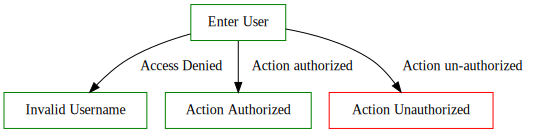

In [52]:
enterUserNode.display(globalVisited)

In [53]:
individualBranches = enterUserNode.getIndividualBranches()
print(individualBranches)
print('testData: ' + str(individualBranches[0][0].testData))
print('Children: ' + str(individualBranches[0][1].children))
print(individualBranches[0][1] is individualBranches[1][1])

[[Invalid Username, Enter User], [Action Authorized, Enter User], [Action Unauthorized, Enter User]]
testData: [['nonExistentUser', 'addUser']]
Children: []
False


In [54]:
def mergeIndividualBranchNodes(individualBranches):
    for individualBranch in individualBranches:
        for node in individualBranch:
            # Set test data for all nodes of the branch to be the same as the leaf node
            node.testData = individualBranch[0].testData
            print(node.description + " , testData:" + str(node.testData))
        
        # Reverse since the 'Start' node is at the end of the list
        individualBranch.reverse()
        i = 1
        while(i < len(individualBranch)):
            individualBranch[i - 1].addChild(individualBranch[i])
            i = i + 1

mergeIndividualBranchNodes(individualBranches)
print(individualBranches)

Invalid Username , testData:[['nonExistentUser', 'addUser']]
Enter User , testData:[['nonExistentUser', 'addUser']]
Action Authorized , testData:[['adminUser', 'addUser']]
Enter User , testData:[['adminUser', 'addUser']]
Action Unauthorized , testData:[]
Enter User , testData:[]
[[Enter User, Invalid Username], [Enter User, Action Authorized], [Enter User, Action Unauthorized]]


In [60]:
def executeIndividualBranch(individualBranch):
    print(individualBranch)
    print("testdata: " + str(individualBranch[0].testData))
    startNode = individualBranch[0]
    startNode.setPriorActionResults({})
    for singleTestData in startNode.testData:
        startNode.isActivationEligible(singleTestData)
    startNode.activate(set())

executeIndividualBranch(individualBranches[1])

[Enter User, Action Authorized]
testdata: [['adminUser', 'addUser']]
Enter User Node Activation!!
action complete, actionResults:  {'Enter User': ['addUser', 'deleteUser', 'editUser', 'getUser']}
Action is Authorized
action complete, actionResults:  {'Enter User': ['addUser', 'deleteUser', 'editUser', 'getUser'], 'Action Authorized': None}
